In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../models')
from vgg import VGG16_model

import os
import random
from imutils import paths
from collections import defaultdict 
import numpy as np
import time

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Fixing Random Seeds

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Initializing parameters

In [3]:
DATA_DIR = '../data'
CROSS_VAL_DIR = '../data/cross_validation'
MODEL_SAVE_DIR = '../trained_models'
MODEL_SAVE_NAME = 'vgg_trained.pt'
N_EPOCHS = 5
FOLD = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 1e-4
BATCH_SIZE = 16
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Create the model save dir if it already doesn't exist
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

### Load the Pocovid Dataset according to the fold passed

In [4]:
import sys
sys.path.append('../scripts')
from pocovid_dataset import PocovidDataset
from torch.utils.data import Dataset, DataLoader

In [5]:
def get_train_test_paths():
    
    imagePaths = list(paths.list_images(CROSS_VAL_DIR))

    train_path_info = defaultdict(list)
    test_path_info = defaultdict(list)

    for imagePath in imagePaths:
        path_parts = imagePath.split(os.path.sep)
        fold_number = path_parts[-3][-1]
        label = path_parts[-2]
        if(fold_number==str(FOLD)):
            test_path_info['path_list'].append(imagePath)
            test_path_info['label_list'].append(label)
        else:
            train_path_info['path_list'].append(imagePath)
            train_path_info['label_list'].append(label)

    return train_path_info, test_path_info

In [6]:
train_path_info, test_path_info = get_train_test_paths()

In [7]:
# Get the train and test data according to the fold 

train_transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
                                   transforms.RandomAffine(10,translate=(0.1,0.1)),
                                   transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
                                   transforms.ToTensor()])

trainset = PocovidDataset(train_path_info, transform = train_transform)
testset = PocovidDataset(test_path_info, transform = test_transform)

num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, shuffle=True,
                                  batch_size=BATCH_SIZE, drop_last=True)

test_loader = torch.utils.data.DataLoader(testset, num_workers=num_workers, shuffle=True,
                                batch_size=BATCH_SIZE)

In [8]:
class_map = {trainset.get_covid_class_idx() : 'covid',
            trainset.get_pneu_class_idx() : 'pneumonia',
            trainset.get_regular_class_idx() : 'regular'}

### Model

In [9]:
model = VGG16_model().to(device)

### Loss function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params = model.parameters(), lr=LR) #experiment with weigth_decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95) # use scheduler

### Train and Eval functions

In [11]:
def train(model, optimizer, criterion, iterator):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        inputs, labels = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [12]:
def evaluate(model, criterion, iterator):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):    
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Epoch Time Measuring 

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [14]:
best_valid_loss = np.inf
c = 0

for epoch in range(N_EPOCHS):
    
    print(f'Epoch: {epoch+1:02}')

    start_time = time.time()

    train_loss = train(model, optimizer, criterion, train_loader)
    valid_loss = evaluate(model, criterion, test_loader)

    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
    
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, MODEL_SAVE_NAME))
        c=0
 
    if c>4:
        #decrease lr if loss does not decrease after 5 steps
        scheduler.step()
        c=0

    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')
    print('-'*100)
print(best_valid_loss)

Epoch: 01
Time: 0m 19s
Train Loss: 0.636
Val   Loss: 0.905
----------------------------------------------------------------------------------------------------
Epoch: 02
Time: 0m 19s
Train Loss: 0.390
Val   Loss: 0.849
----------------------------------------------------------------------------------------------------
Epoch: 03
Time: 0m 19s
Train Loss: 0.294
Val   Loss: 0.850
----------------------------------------------------------------------------------------------------
Epoch: 04
Time: 0m 19s
Train Loss: 0.230
Val   Loss: 0.782
----------------------------------------------------------------------------------------------------
Epoch: 05
Time: 0m 19s
Train Loss: 0.198
Val   Loss: 0.767
----------------------------------------------------------------------------------------------------
0.7671659569377485


### Testing

In [18]:
# Load the model here, if you are testing
# uncomment while testing

# model = VGG16_model().to(device) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, MODEL_SAVE_NAME), map_location=device))

<All keys matched successfully>

In [19]:
def test(model, iterator, proba=False, one_batch=False):
    
    model.eval()
    
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):    
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            outputs = model(inputs)
            
            y_prob = F.softmax(outputs, dim = -1)
            
            top_preds = y_prob.argmax(1, keepdim = True)
            
            images.append(inputs.to(device))
            true_labels.append(labels.to(device))
            pred_labels.append(top_preds.to(device))
            pred_probs.append(y_prob.to(device))
            
            if(one_batch):
                break
            
    images = torch.cat(images, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    pred_labels = torch.cat(pred_labels, dim=0)
    pred_probs = torch.cat(pred_probs, dim=0)

    
    if(proba):
        return images, true_labels, pred_labels, pred_probs
            
    return images, true_labels, pred_labels

In [20]:
images, true_labels, pred_labels = test(model, test_loader)

### Plot Confusion Matrix

In [21]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

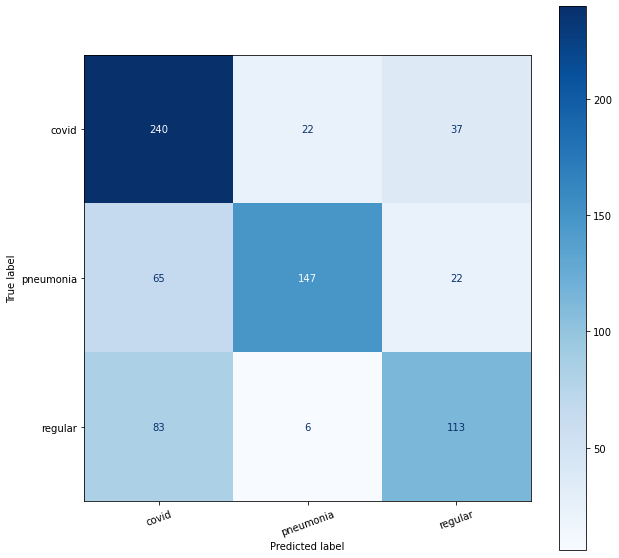

In [22]:
plot_confusion_matrix(true_labels.cpu().numpy(), pred_labels.cpu().numpy(), ['covid', 'pneumonia', 'regular'])

# Use this in the training script
#cm = confusion_matrix(true_labels.cpu().numpy(), pred_labels.cpu().numpy())
#print(cm)

### Get the Classification Report

In [23]:
print(classification_report(
        true_labels.cpu().numpy(), pred_labels.cpu().numpy(), target_names= ['covid', 'pneumonia', 'regular']
    ))

              precision    recall  f1-score   support

       covid       0.62      0.80      0.70       299
   pneumonia       0.84      0.63      0.72       234
     regular       0.66      0.56      0.60       202

    accuracy                           0.68       735
   macro avg       0.71      0.66      0.67       735
weighted avg       0.70      0.68      0.68       735



### Visualize Sample Test Results

In [24]:
def visualize_test_samples(model, test_loader):
    
    images, true_labels, pred_labels, pred_probs = test(model, test_loader, proba=True, one_batch=True)

    true_labels = true_labels.cpu().numpy()
    pred_labels = pred_labels.cpu().numpy()
    pred_probs = pred_probs.cpu().numpy()


    rows = int(np.sqrt(len(images)))
    cols = int(np.sqrt(len(images)))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, pred_label, pred_prob = images[i], true_labels[i], pred_labels[i], pred_probs[i]
        image = image.permute(1, 2, 0)
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {class_map[true_label]}\n' \
                    f'pred label: {class_map[pred_label[0]]} (Prob: {max(pred_prob):.3f})',
                    color = ('green' if true_label==pred_label[0] else 'red'))
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)
    
    plt.show()

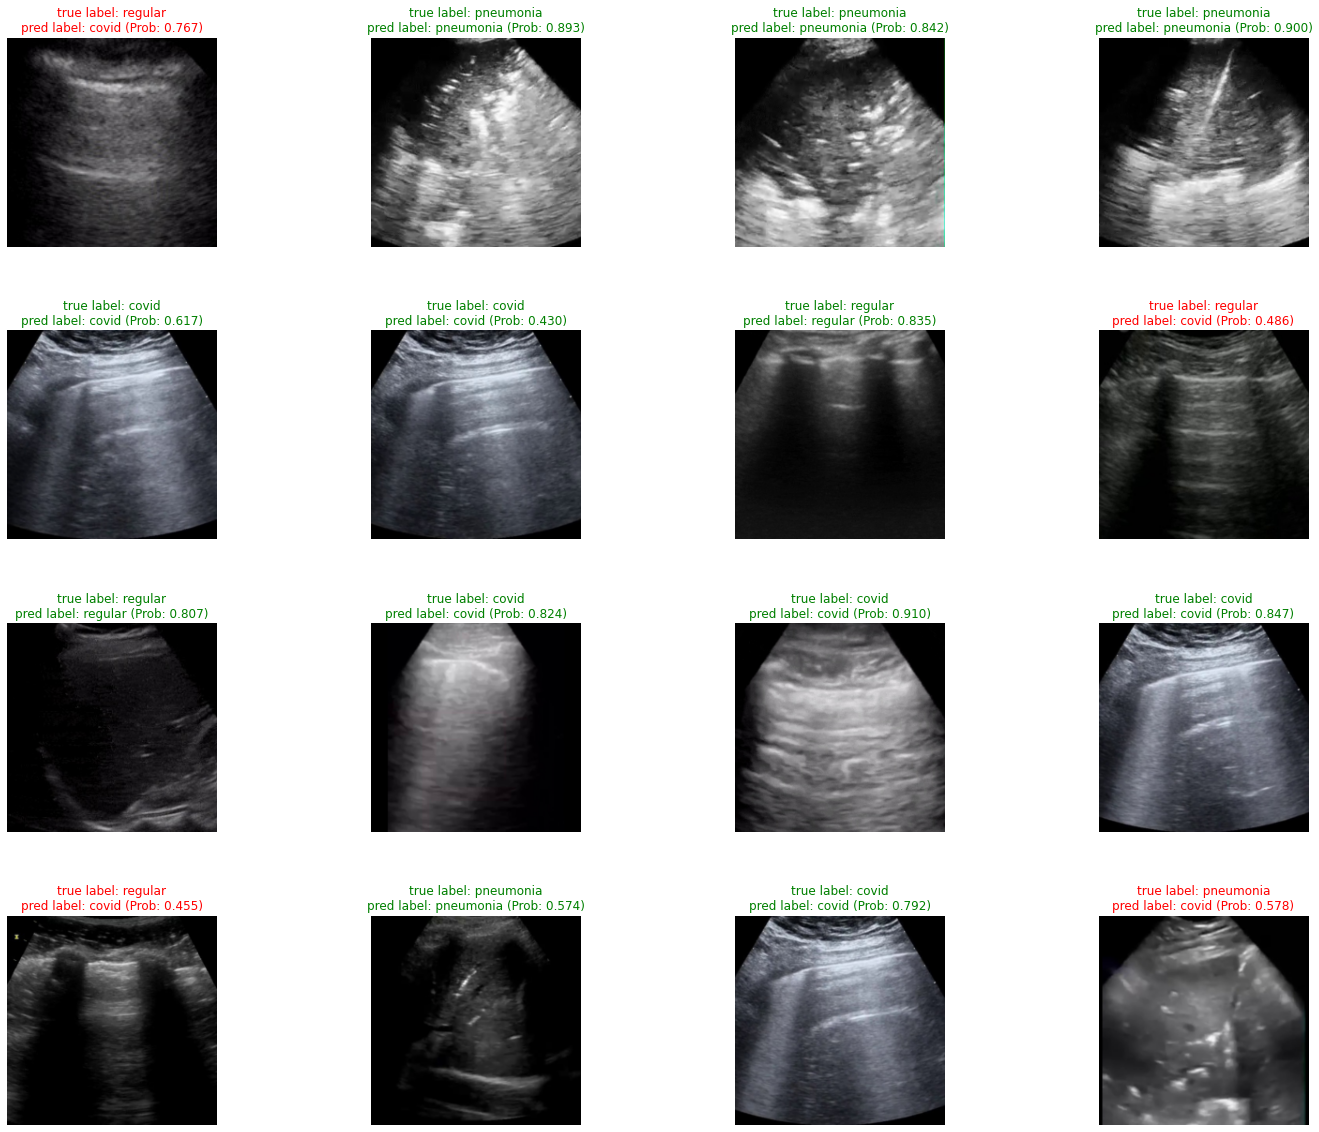

In [25]:
visualize_test_samples(model, test_loader)

In [ ]:
# ROC Curve #
# original code for this graphic can be found here
# /jannisborn/covid19_pocus_ultrasound/blob/master/pocovidnet/notebooks/analysis/crossval_evaluate.ipynb
# will use this as a guide

In [ ]:
# Todo:
# 1) Implement ROC graph with confidence values (J)
# 2) Hypertune the paramaters for best results (N)
# 3) Implement voting classifier from all 5 folds using 5 models (A)
# 4) Add code for early stopping (A)
# 5) Do visualization stuff (N)
# 6) Refactor all code and make the training and testing scripts with args (A)
# 7) Finalize this notebook with all code included (A)
# 8) Implement the flask api (A)
# 9) Test the script and prepare a notebook for Resnet model (J)